# Task 4: Mitigating Bias (LR)

In this notebook, you will train a Decision Tree model to predict the `prior_hiring_decision` target variable. You should compare its performance (Accuracy and Fairness) to the Logistic Regression baseline.

In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print("Training Shape:", train_df.shape)

Training Shape: (30000, 13)


## Preprocessing Mitigation

In [72]:
# TODO: Train Decision Tree and Report Accuracy + Fairness Metrics
import importlib
import utils
importlib.reload(utils)
from utils import preprocess_data, compute_reweighing_weights  # since notebook is in src/, this is correct
data, clf = preprocess_data(train_df, val_df, test_df, 
                            sensitive_col='is_white', 
                            classifier=LogisticRegression(max_iter=1000))
weight = compute_reweighing_weights(data['sensitive_val'], data['y_train'])
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
sensitive_val = data['sensitive_val']
sensitive_test = data['sensitive_test']

Using Features: ['Age', 'Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Hours_Per_Week', 'Sex', 'Place_Of_Birth', 'interview_score', 'cv_assessment_score']
Numerical: ['Age', 'Hours_Per_Week', 'interview_score', 'cv_assessment_score']
Categorical: ['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Sex', 'Place_Of_Birth']


## Fit and validate the classifier

In [73]:
# Train Classifier
clf.fit(X_train, y_train, classifier__sample_weight=weight)
# Validate Classifier
y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1]
accuracy_val = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy (reweight): {accuracy_val:.4f}')

Validation Accuracy (reweight): 0.7289


## Post-processing Mitigation
### Perform grid search on tau a and b in range 0.3 to 0.8
results are logged and will be used to find the best parameter later

In [74]:

importlib.reload(utils)
from utils import post_process_mitigation, fairness_metrics, group_tpr


tau_as = np.linspace(0.3, 0.8, 50)  # initial thresholds
tau_bs = np.linspace(0.3, 0.8, 50)  # initial thresholds
TAU_A, TAU_B = np.meshgrid(tau_as, tau_bs, indexing="ij")
results = {
           "tau_as": TAU_A, "tau_bs": TAU_B, 
           "achieved_tprs": np.zeros((len(tau_as), len(tau_bs))), 
           "accuracies": np.zeros((len(tau_as), len(tau_bs))), 
           "fairness_gaps": np.zeros((len(tau_as), len(tau_bs)))}
for i, tau_a in enumerate(tau_as):
    for j, tau_b in enumerate(tau_bs):
        # Apply different thresholds for different groups
        y_pred_post_process = post_process_mitigation(y_pred_proba, sensitive_val, tau_a, tau_b)

        _acc_threshold = accuracy_score(y_val, y_pred_post_process)
        fairness_results, fairness_gaps = fairness_metrics(y_val, y_pred_post_process, sensitive_val)
        print("==="*10)
        print(f"Post-Processing | Accuracy={_acc_threshold:.4f} | Tau_a={tau_a:.4f}, Tau_b={tau_b:.4f} | delta accuracy={_acc_threshold - accuracy_val:.4f}")
        for metric, gap in fairness_gaps.items():
            print(f"{metric} Gap: {gap}")
        tpr0 = group_tpr(y_val, y_pred_post_process, sensitive_val, 0)
        tpr1 = group_tpr(y_val, y_pred_post_process, sensitive_val, 1)
        achieved = 0.5 * (tpr0 + tpr1)
        results["accuracies"][i, j] = _acc_threshold
        results["fairness_gaps"][i, j] = fairness_gaps['EO_gap_|TPR(A=1)-TPR(A=0)|']
        results["achieved_tprs"][i, j] = achieved


Post-Processing | Accuracy=0.6991 | Tau_a=0.3000, Tau_b=0.3000 | delta accuracy=-0.0298
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.21039529151393221
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.08984513441970621
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.20891117228777345
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.20891117228777345
Post-Processing | Accuracy=0.7013 | Tau_a=0.3000, Tau_b=0.3102 | delta accuracy=-0.0276
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.20142668164846134
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.08473081432343665
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.19555500790421176
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.19555500790421176
Post-Processing | Accuracy=0.7036 | Tau_a=0.3000, Tau_b=0.3204 | delta accuracy=-0.0253
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.19197761054019735
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.07931565186856304
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.18151391201380085
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.18151391201380085
Post-Processing | Accuracy=0.7055 | Tau_a=0.3000, Tau_b=0.3306 | delta ac

### Get the best accuracy under fairness metric under a certain value

In [75]:
# Find best accuracy under EO gap < Metric_threshold
Metric_threshold = 0.01
rows, cols = np.where(results['fairness_gaps'] < Metric_threshold)
filtered_accuracies = results['accuracies'][rows, cols]
best_accuracy_idx = np.argmax(filtered_accuracies)
best_k = np.argmax(filtered_accuracies)
i_best = rows[best_k]
j_best = cols[best_k]
fairness_metric_value = results['fairness_gaps'][i_best, j_best]
best_accuracy = filtered_accuracies[best_k]
tau_a_best = tau_as[i_best]
tau_b_best = tau_bs[j_best]
print(f'Tau_a={tau_a_best:.4f}, Tau_b={tau_b_best:.4f} achieve Accuracy={best_accuracy:.4f} under EO gap<{Metric_threshold}')

Tau_a=0.4020, Tau_b=0.5449 achieve Accuracy=0.7260 under EO gap<0.01


# Results
## Validation Results

In [76]:
EO_reweighted = fairness_metrics(y_val, y_pred, sensitive_val)[1]['EO_gap_|TPR(A=1)-TPR(A=0)|']
print(f"Validation Set | Accuracy={accuracy_val:.4f} | Accuracy Post-Processed={best_accuracy:.4f}")
print(f"EO(threshold): {fairness_metric_value:.4f} | EO(reweighted): {EO_reweighted:.4f}")

Validation Set | Accuracy=0.7289 | Accuracy Post-Processed=0.7260
EO(threshold): 0.0065 | EO(reweighted): 0.1544


## Test Results

In [77]:
y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

y_test_pred_post_process = post_process_mitigation(y_test_pred_proba, sensitive_test, tau_a_best, tau_b_best)
test_accuracy_post = accuracy_score(y_test, y_test_pred_post_process)
test_accuracy = accuracy_score(y_test, y_test_pred)
_, fairness_gaps_test_post = fairness_metrics(y_test, y_test_pred_post_process, sensitive_test)
_, fairness_gaps_test = fairness_metrics(y_test, y_test_pred, sensitive_test)
print(f"Test Set | Accuracy={test_accuracy:.4f} | Accuracy Post-Processed={test_accuracy_post:.4f}")
print(f"EO(threshold)={fairness_gaps_test_post['EO_gap_|TPR(A=1)-TPR(A=0)|']:.4f} | EO(reweight)={fairness_gaps_test['EO_gap_|TPR(A=1)-TPR(A=0)|']:.4f}")

Test Set | Accuracy=0.7225 | Accuracy Post-Processed=0.7186
EO(threshold)=0.0064 | EO(reweight)=0.1516


## Get plots

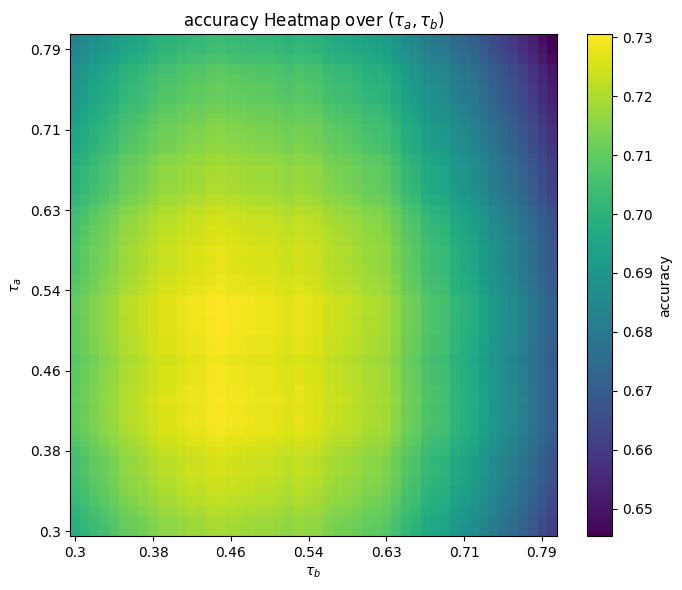

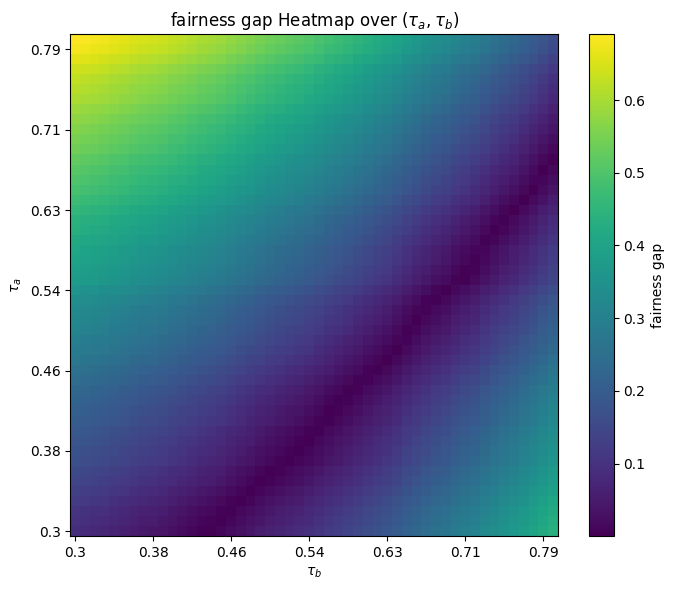

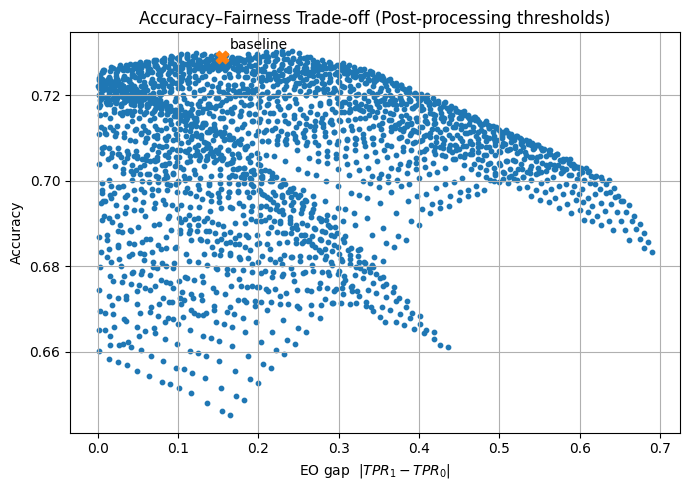

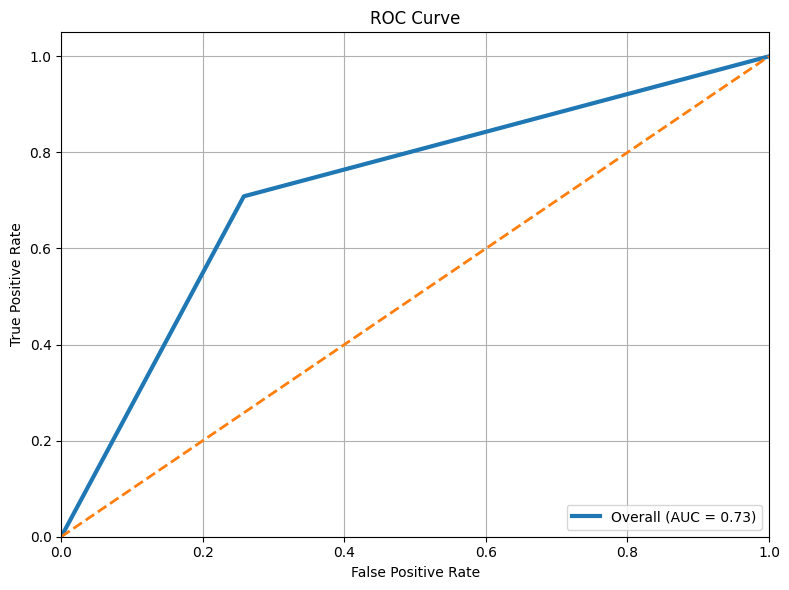

In [78]:
importlib.reload(utils)
from utils import plot_roc_curve, post_process_mitigation, plot_tradeoff, plot_attribute_on_thresholds

plot_attribute_on_thresholds(tau_as, tau_bs, results["accuracies"], "accuracy")
plot_attribute_on_thresholds(tau_as, tau_bs, results["fairness_gaps"], "fairness gap")
plot_tradeoff(results["accuracies"], results["fairness_gaps"],
              baseline_acc=accuracy_score(y_val, y_pred),
              baseline_eo=fairness_metrics(y_val, y_pred, sensitive_val)[1]['EO_gap_|TPR(A=1)-TPR(A=0)|'])

y_pred_proba_post = post_process_mitigation(y_pred_proba, sensitive_val, tau_a_best, tau_b_best)
plot_roc_curve(y_val, y_pred_proba_post)